In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from collections import Counter

# NLP and Text Processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import cmudict
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# Local
from classes.song import Song
from classes.spotify_manager import SpotifyManager
from classes.lyrics_manager import LyricsManager
from classes.utils import gather_data_from_folders
from classes.model_pipeline import OptimalRegressionPipeline, OptimalClassificationPipeline
from classes.baseline_models import MeanBaselineModel, MajorityBaselineModel, RandomBaselineModel

import warnings
warnings.simplefilter('ignore')
load_dotenv();

In [3]:
df = pd.read_pickle(os.path.join('datasets', "new_data.pkl"))
print(f"Loaded {df.shape[0]} songs")
df.head()

Loaded 3621 songs


,id,title,artist,album_art_url,popularity,explicit,album_release_year,duration_ms,genres,lyrics,...,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99,genre
0,6YDDrg8llsRtAgLlIROzZc,put your head on my shoulder,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,68.0,0,1959,158906,"['genre:pop', 'adult', 'standards', 'canadian'...",Put your head on my shoulder\nHold me in your ...,...,-0.003423,0.016568,0.002319,0.007630,-0.003030,0.009287,0.006670,0.003556,0.003469,pop
1,5zvOXJrzzUlvXwyuwZ0toZ,oh! carol,neil sedaka,https://i.scdn.co/image/ab67616d0000b2733843b4...,58.0,0,1959,136562,"['genre:pop', 'adult', 'standards', 'brill', '...","Oh! Carol\nI am but a fool\nDarling, I love yo...",...,-0.004206,-0.010597,0.007079,-0.003365,0.015292,-0.004908,0.000558,-0.006474,0.000418,pop
2,0QGwOFQChzflLAmPq5NwKo,a teenager in love,dion & the belmonts,https://i.scdn.co/image/ab67616d0000b2737a6091...,61.0,0,1959,158253,"['genre:pop', 'brill', 'building', 'pop', 'doo...",Each time we have a quarrel\nIt almost breaks ...,...,-0.005288,-0.016978,0.001973,0.016645,0.005722,-0.000172,0.000788,-0.002016,0.009753,pop
3,0hjYuU2Z9jcKvOl39oUpeE,diana,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,56.0,0,1959,147760,"['genre:pop', 'adult', 'standards', 'canadian'...","I'm so young and you're so old\nThis, my darli...",...,-0.002524,-0.011046,-0.001598,-0.004006,0.001692,0.002618,0.004807,-0.001807,-0.000070,pop
4,1mdfrHeZzxjz0FJ4BKRuxS,puppy love,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,57.0,0,1959,161533,"['genre:pop', 'adult', 'standards', 'canadian'...",And they called it puppy love\nOh I guess they...,...,-0.005602,0.010182,-0.006879,-0.001400,-0.001735,-0.001136,-0.004035,0.016890,0.001792,pop


In [4]:
df.head()

,id,title,artist,album_art_url,popularity,explicit,album_release_year,duration_ms,genres,lyrics,...,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99,genre
0,6YDDrg8llsRtAgLlIROzZc,put your head on my shoulder,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,68.0,0,1959,158906,"['genre:pop', 'adult', 'standards', 'canadian'...",Put your head on my shoulder\nHold me in your ...,...,-0.003423,0.016568,0.002319,0.007630,-0.003030,0.009287,0.006670,0.003556,0.003469,pop
1,5zvOXJrzzUlvXwyuwZ0toZ,oh! carol,neil sedaka,https://i.scdn.co/image/ab67616d0000b2733843b4...,58.0,0,1959,136562,"['genre:pop', 'adult', 'standards', 'brill', '...","Oh! Carol\nI am but a fool\nDarling, I love yo...",...,-0.004206,-0.010597,0.007079,-0.003365,0.015292,-0.004908,0.000558,-0.006474,0.000418,pop
2,0QGwOFQChzflLAmPq5NwKo,a teenager in love,dion & the belmonts,https://i.scdn.co/image/ab67616d0000b2737a6091...,61.0,0,1959,158253,"['genre:pop', 'brill', 'building', 'pop', 'doo...",Each time we have a quarrel\nIt almost breaks ...,...,-0.005288,-0.016978,0.001973,0.016645,0.005722,-0.000172,0.000788,-0.002016,0.009753,pop
3,0hjYuU2Z9jcKvOl39oUpeE,diana,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,56.0,0,1959,147760,"['genre:pop', 'adult', 'standards', 'canadian'...","I'm so young and you're so old\nThis, my darli...",...,-0.002524,-0.011046,-0.001598,-0.004006,0.001692,0.002618,0.004807,-0.001807,-0.000070,pop
4,1mdfrHeZzxjz0FJ4BKRuxS,puppy love,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,57.0,0,1959,161533,"['genre:pop', 'adult', 'standards', 'canadian'...",And they called it puppy love\nOh I guess they...,...,-0.005602,0.010182,-0.006879,-0.001400,-0.001735,-0.001136,-0.004035,0.016890,0.001792,pop


In [5]:
spotify_features = ['popularity', 'explicit',
       'album_release_year', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature']

sentiment_features = ['sentiment_polarity', 'sentiment_subjectivity', 'vader_compound', 'sentiment_variability']

lyrics_features = ['unique_word_count', 'noun_ratio',
       'verb_ratio', 'repetition_count', 'language', 'genre',
       'lexical_richness', 'semantic_depth', 'syntactic_complexity',
       'rhyme_density',  'linguistic_uniqueness', 'flesch_reading_ease', 
        'gunning_fog', 'dale_chall', 'type_token_ratio', 'word_count']

tfidf_features = [ f for f in df.columns if f.startswith("tfidf_") ]

w2v_features = [ f for f in df.columns if f.startswith("w2v") ]

empath_features = [ f for f in df.columns if f.startswith("empath") ]

audio_extracted_features = ['mfcc_1', 'mfcc_2',
       'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
       'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8',
       'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'spectral_contrast_1', 'spectral_contrast_2', 'spectral_contrast_3',
       'spectral_contrast_4', 'spectral_contrast_5', 'spectral_contrast_6',
       'spectral_contrast_7', 'tempo_extracted', 'zcr']


---

# Classification

<Axes: >

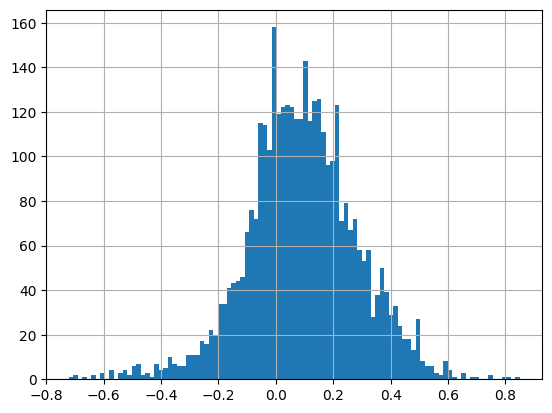

In [6]:
df.sentiment_polarity.hist(bins=100)

In [7]:
df['sentiment_polarity_binary'] = df.sentiment_polarity.apply(lambda x: x >= 0).astype(int)
df['sentiment_polarity_binary'].value_counts()

sentiment_polarity_binary
1    2535
0    1086
Name: count, dtype: int64

## Prediction with all features

In [8]:
target = 'sentiment_polarity_binary'
features = [ f for f in spotify_features + lyrics_features + tfidf_features + w2v_features + empath_features + audio_extracted_features if f in df.columns ]

In [9]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [10]:
cat_features

['explicit', 'key', 'mode', 'time_signature', 'language', 'genre']

In [11]:
len(num_features)

454

In [12]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=20,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: sentiment_polarity_binary
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['w2v_78',
                                                                    'empath_occupation',
                                                                    'w2v_90',
                                                                    'chroma_10',
                                                                    'chroma_3',
                                                                    'empath_superhero',
                                                                    'empath_sexual',
                                                                    'empath_royalty',
                                                                    'tfidf_45',
                                                                    'tfidf_...
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['time_signature',
                                                                    'key',
                                                                    'explicit',
                                                                    'genre',
                                                                    'mode',
                                                                    'language'])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x79abb7fb2830>)])

In [13]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-21 00:35:49,027] A new study created in memory with name: catboost_sentiment_polarity_binary
[I 2024-12-21 00:40:44,078] Trial 2 finished with value: 0.7514513033380323 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.027063787507248326, 'l2_leaf_reg': 2.9462868629829284}. Best is trial 2 with value: 0.7514513033380323.
[I 2024-12-21 00:40:56,530] Trial 1 finished with value: 0.7432221174132234 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.02950068879338457, 'l2_leaf_reg': 8.854171198927201}. Best is trial 2 with value: 0.7514513033380323.
[I 2024-12-21 00:41:41,344] Trial 7 finished with value: 0.7493107476085287 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.06755434026240849, 'l2_leaf_reg': 6.242982974640466}. Best is trial 2 with value: 0.7514513033380323.
[I 2024-12-21 00:44:23,512] Trial 10 finished with value: 0.7466771906051175 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.0447440091035

INFO: Pipeline training completed.


In [14]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.766
1,F1 Score,0.754
2,Precision,0.755
3,Recall,0.766


INFO: Evaluating the model...


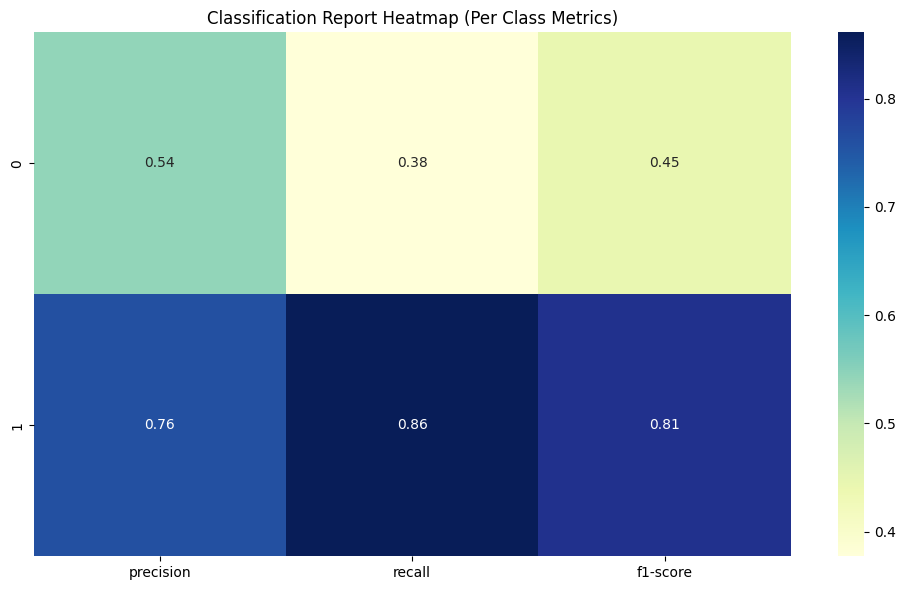

,precision,recall,f1-score,support
0,0.542484,0.377273,0.445040,220.000000
1,0.760490,0.861386,0.807799,505.000000
accuracy,0.714483,0.714483,0.714483,0.714483
macro avg,0.651487,0.619329,0.626420,725.000000
weighted avg,0.694336,0.714483,0.697721,725.000000


In [15]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


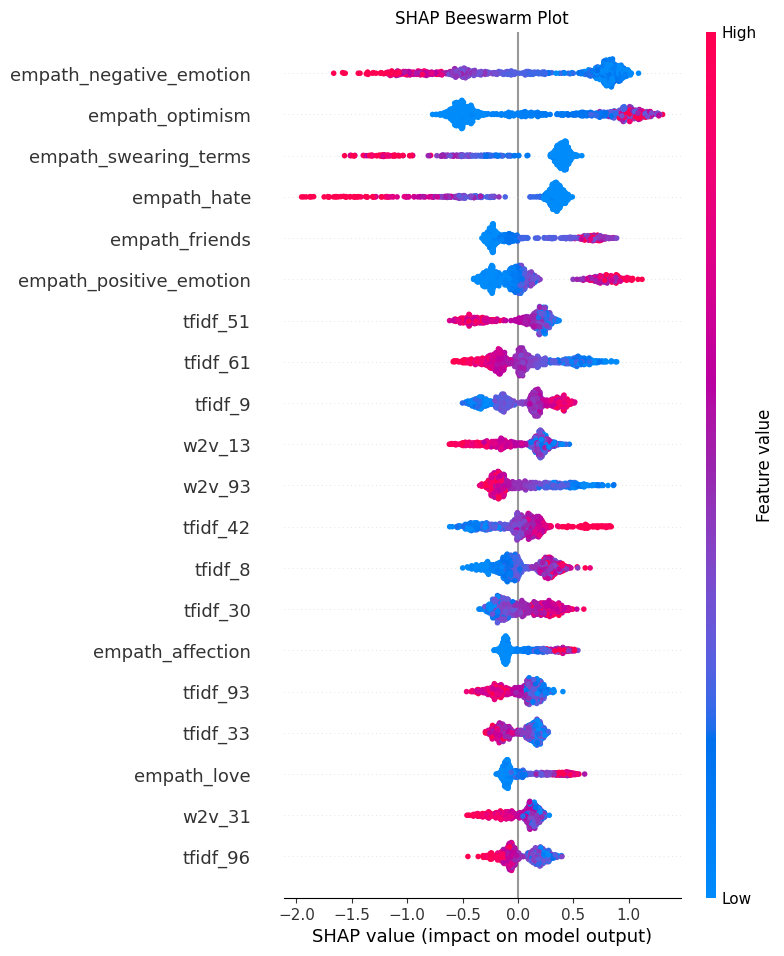

INFO: Generating feature importance bar plot...


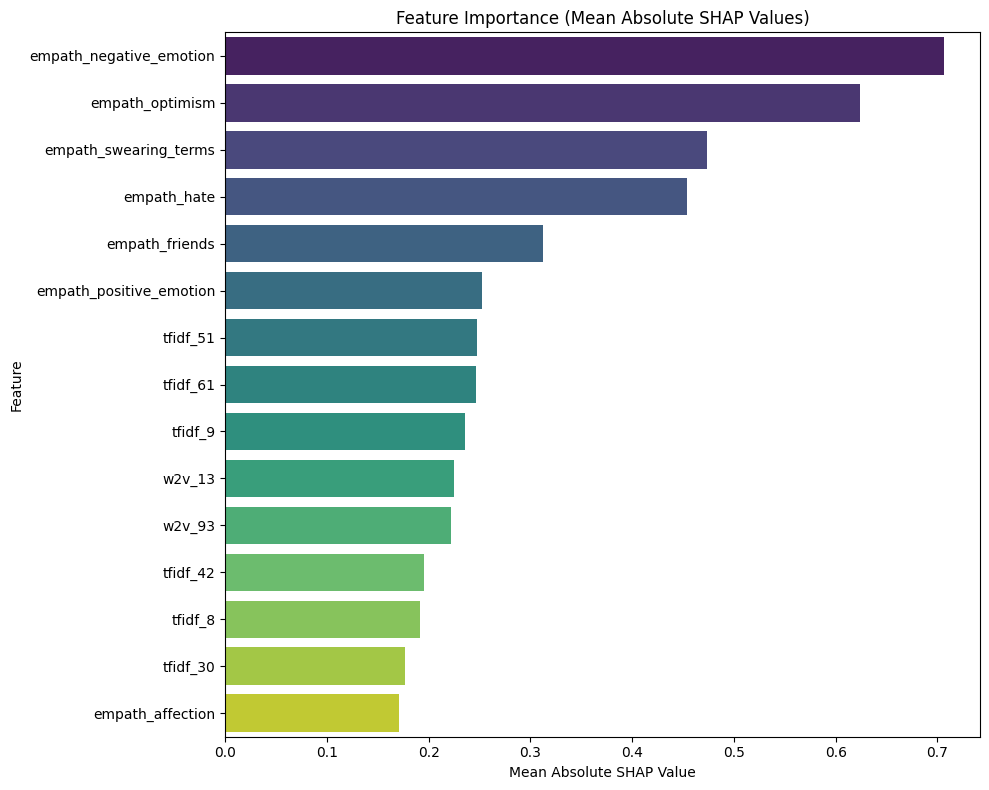

In [16]:
pipeline.perform_shap_analysis()

## Prediction with lyrics

In [17]:
target = 'sentiment_polarity_binary'
features = [ f for f in lyrics_features + tfidf_features + w2v_features + empath_features if f in df.columns ]

In [18]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [19]:
cat_features

['language', 'genre']

In [20]:
len(num_features)

408

In [21]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=20,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: sentiment_polarity_binary
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['w2v_78',
                                                                    'empath_occupation',
                                                                    'w2v_90',
                                                                    'empath_superhero',
                                                                    'empath_sexual',
                                                                    'empath_royalty',
                                                                    'tfidf_45',
                                                                    'tfidf_20',
                                                                    'gunning_fog',
                                                                    'empa...
                                                                                                  strategy='constant')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['genre',
                                                                    'language'])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x79abb45899f0>)])

In [22]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-21 01:14:07,966] A new study created in memory with name: catboost_sentiment_polarity_binary
[I 2024-12-21 01:16:18,564] Trial 6 finished with value: 0.7518765842285416 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.043323215554498376, 'l2_leaf_reg': 3.3845294729046076}. Best is trial 6 with value: 0.7518765842285416.
[I 2024-12-21 01:16:23,007] Trial 0 finished with value: 0.7307767782777167 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.021465605219893512, 'l2_leaf_reg': 2.5913739400962488}. Best is trial 6 with value: 0.7518765842285416.
[I 2024-12-21 01:18:54,022] Trial 8 finished with value: 0.7401296944043525 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.09528655047703101, 'l2_leaf_reg': 7.337547074787782}. Best is trial 6 with value: 0.7518765842285416.
[I 2024-12-21 01:18:58,988] Trial 4 finished with value: 0.7482847237030745 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.0505233426617

INFO: Pipeline training completed.


In [23]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.765
1,F1 Score,0.755
2,Precision,0.754
3,Recall,0.765


INFO: Evaluating the model...


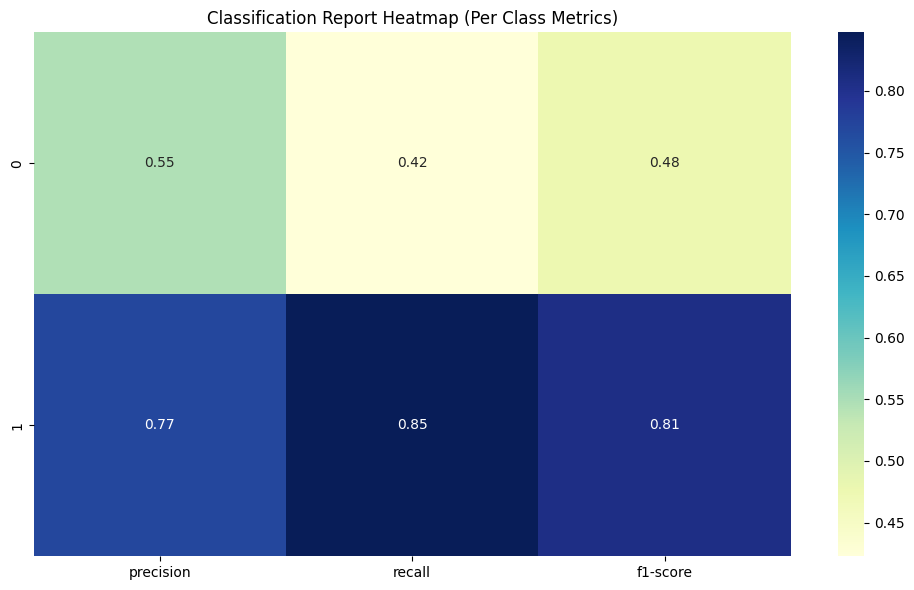

,precision,recall,f1-score,support
0,0.547059,0.422727,0.476923,220.000000
1,0.771171,0.847525,0.807547,505.000000
accuracy,0.718621,0.718621,0.718621,0.718621
macro avg,0.659115,0.635126,0.642235,725.000000
weighted avg,0.703165,0.718621,0.707220,725.000000


In [24]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


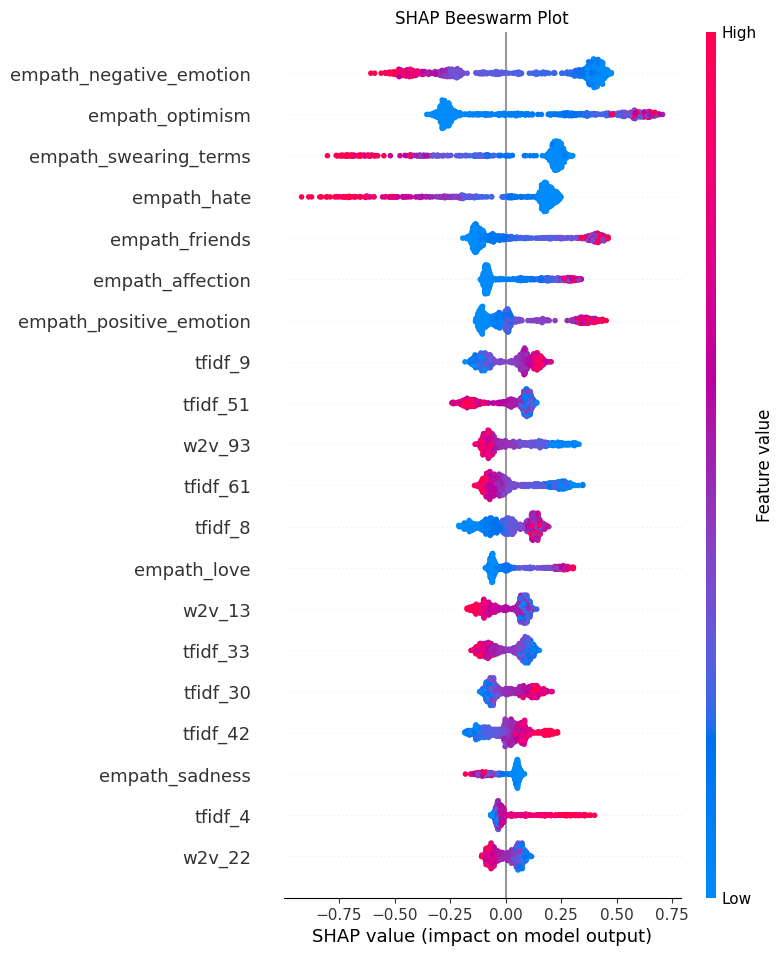

INFO: Generating feature importance bar plot...


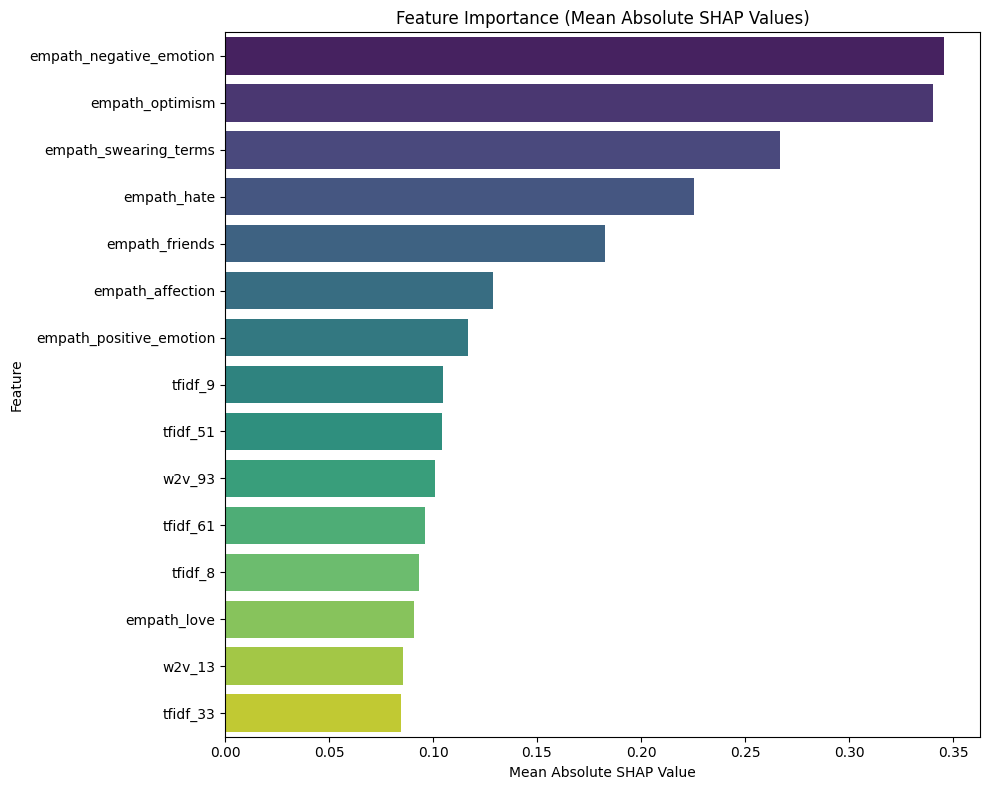

In [25]:
pipeline.perform_shap_analysis()

## Prediction with Spotify Features

In [26]:
target = 'sentiment_polarity_binary'
features = [ f for f in spotify_features if f in df.columns ]

In [27]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [28]:
cat_features

['explicit', 'key', 'mode', 'time_signature']

In [29]:
len(num_features)

12

In [30]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: sentiment_polarity_binary
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['danceability',
                                                                    'tempo',
                                                                    'album_release_year',
                                                                    'valence',
                                                                    'speechiness',
                                                                    'popularity',
                                                                    'instrumentalness',
                                                                    'acousticness',
                                                                    'energy',
                                                                    'livene...
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['time_signature',
                                                                    'explicit',
                                                                    'mode',
                                                                    'key'])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x79abb50b3cd0>)])

In [31]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-21 01:51:43,178] A new study created in memory with name: catboost_sentiment_polarity_binary
[I 2024-12-21 01:51:54,112] Trial 2 finished with value: 0.6086546161192699 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.03919178087561717, 'l2_leaf_reg': 7.1064610563282296}. Best is trial 2 with value: 0.6086546161192699.
[I 2024-12-21 01:51:54,557] Trial 5 finished with value: 0.6203984748224851 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.07258403207722049, 'l2_leaf_reg': 2.4632162381441307}. Best is trial 5 with value: 0.6203984748224851.
[I 2024-12-21 01:52:06,737] Trial 0 finished with value: 0.6215348914822509 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.035349335388913626, 'l2_leaf_reg': 1.5659147814497416}. Best is trial 0 with value: 0.6215348914822509.
[I 2024-12-21 01:52:15,621] Trial 9 finished with value: 0.6184100868082797 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.090839533860

INFO: Pipeline training completed.


In [32]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.661
1,F1 Score,0.638
2,Precision,0.628
3,Recall,0.661


INFO: Evaluating the model...


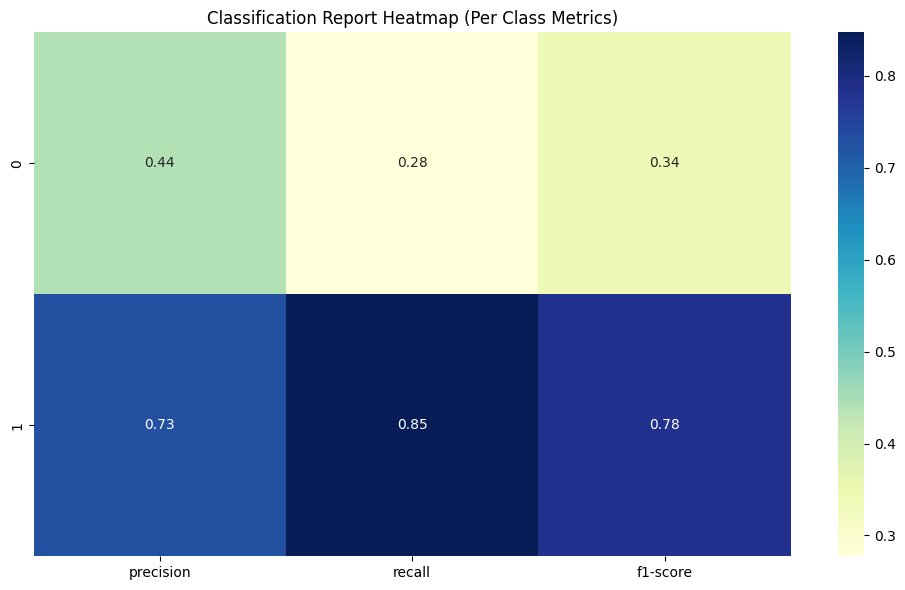

,precision,recall,f1-score,support
0,0.442029,0.277273,0.340782,220.000000
1,0.729131,0.847525,0.783883,505.000000
accuracy,0.674483,0.674483,0.674483,0.674483
macro avg,0.585580,0.562399,0.562332,725.000000
weighted avg,0.642011,0.674483,0.649425,725.000000


In [33]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


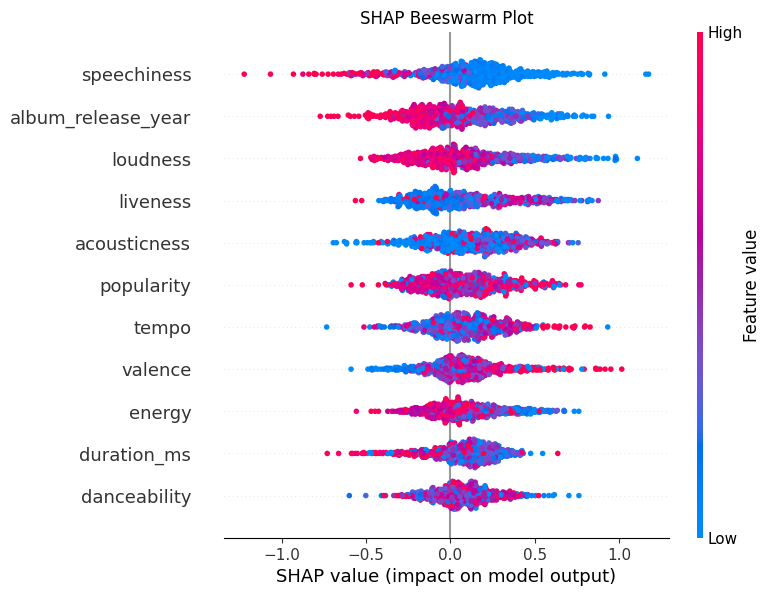

INFO: Generating feature importance bar plot...


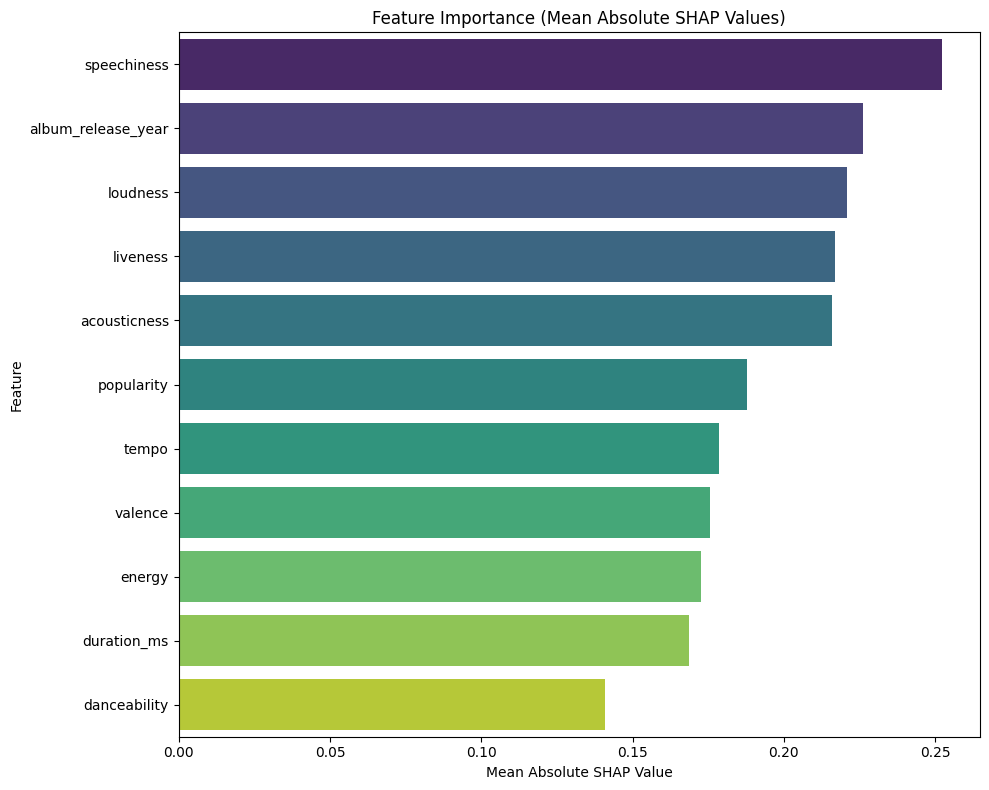

In [34]:
pipeline.perform_shap_analysis()

## Prediction with Audio Features

In [35]:
target = 'sentiment_polarity_binary'
features = [ f for f in audio_extracted_features if f in df.columns ]

In [36]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [37]:
cat_features

[]

In [38]:
len(num_features)

34

In [39]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: sentiment_polarity_binary
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['chroma_6',
                                                                    'zcr',
                                                                    'spectral_contrast_5',
                                                                    'chroma_10',
                                                                    'tempo_extracted',
                                                                    'chroma_3',
                                                                    'mfcc_7',
                                                                    'mfcc_8',
                                                                    'chroma_1',
                                                                    'mfcc_4',
                                                                    'spectral_con...
                                                                                                  strategy='constant')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   [])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x79abb4f246d0>)])

In [40]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-21 01:53:21,969] A new study created in memory with name: catboost_sentiment_polarity_binary
[I 2024-12-21 01:53:33,472] Trial 6 finished with value: 0.6247313486623424 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.06368239785301907, 'l2_leaf_reg': 6.007965191595351}. Best is trial 6 with value: 0.6247313486623424.
[I 2024-12-21 01:53:34,409] Trial 2 finished with value: 0.617581537087619 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.03268036036945608, 'l2_leaf_reg': 2.7992132481677903}. Best is trial 6 with value: 0.6247313486623424.
[I 2024-12-21 01:53:41,744] Trial 1 finished with value: 0.6407143559862145 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.08511220150324811, 'l2_leaf_reg': 8.834673713882474}. Best is trial 1 with value: 0.6407143559862145.
[I 2024-12-21 01:53:42,762] Trial 3 finished with value: 0.6423591845071009 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.0988117563396284, 

INFO: Pipeline training completed.


In [41]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.667
1,F1 Score,0.650
2,Precision,0.642
3,Recall,0.667


INFO: Evaluating the model...


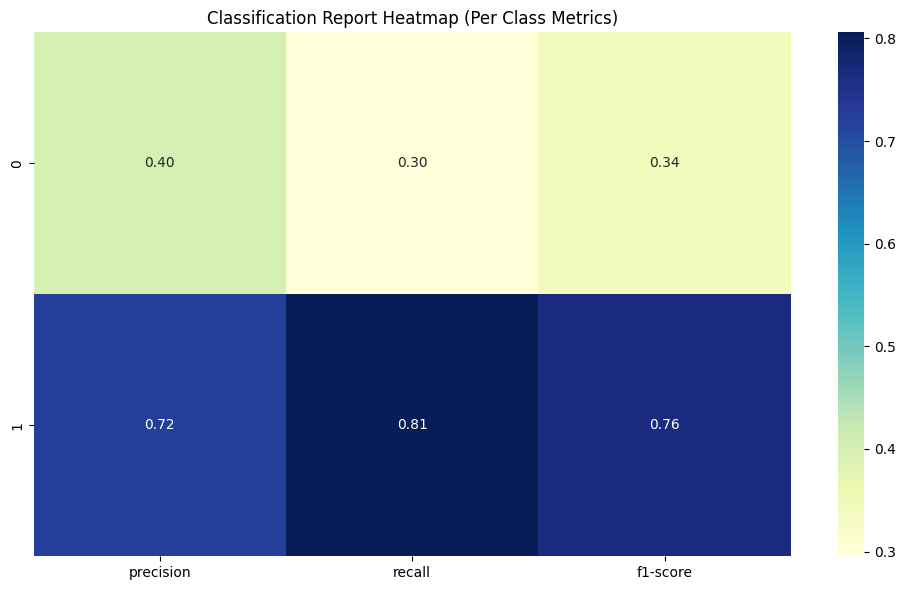

,precision,recall,f1-score,support
0,0.398773,0.295455,0.339426,220.000000
1,0.724199,0.805941,0.762887,505.000000
accuracy,0.651034,0.651034,0.651034,0.651034
macro avg,0.561486,0.550698,0.551156,725.000000
weighted avg,0.625449,0.651034,0.634388,725.000000


In [42]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


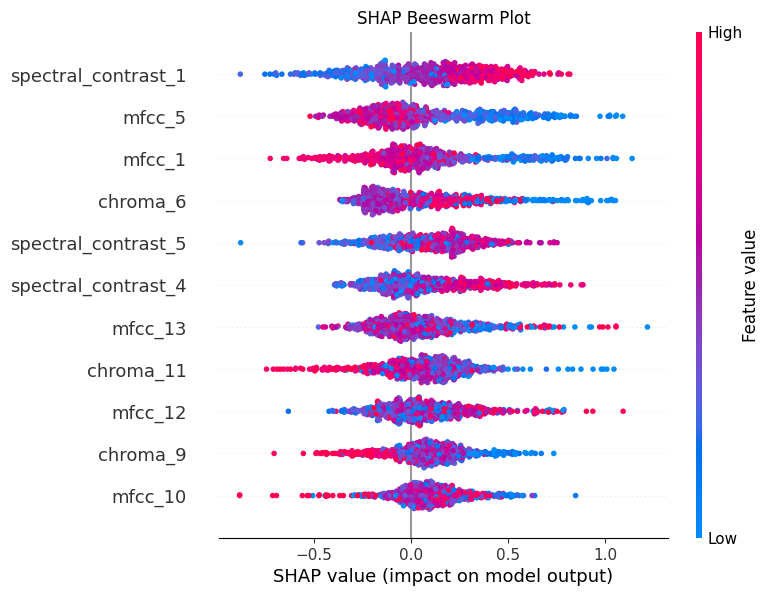

INFO: Generating feature importance bar plot...


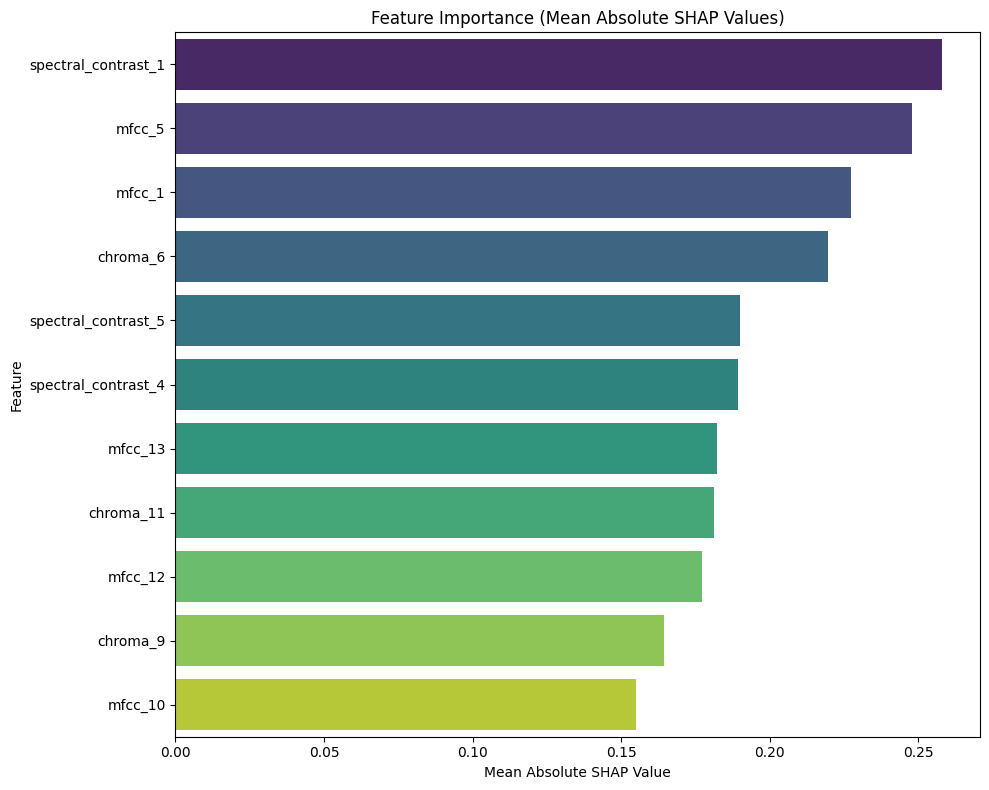

In [43]:
pipeline.perform_shap_analysis()

## Baseline

In [46]:
majority_model = MajorityBaselineModel()
majority_model.fit(pipeline.X_train, pipeline.y_train)
y_pred = majority_model.predict(pipeline.X_test)
majority_model.evaluate(pipeline.y_test, y_pred)

,Score
Accuracy,0.696552
Precision,0.485184
Recall,0.696552
F1 Score,0.571965


In [47]:
random_model = RandomBaselineModel()
random_model.fit(pipeline.X_train, pipeline.y_train)
y_pred = random_model.predict(pipeline.X_test)
random_model.evaluate(pipeline.y_test, y_pred)

,Score
Accuracy,0.525517
Precision,0.601363
Recall,0.525517
F1 Score,0.544606
